In [1]:
import os, re, time, pickle, collections, importlib, datetime, torch, nltk, pandas as pd, numpy as np, random
from chardet import detect
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from model import MaskedEdgeAttention, MaskedNLLLoss, LSTMModel, GRUModel, DialogRNNModel, DialogueGCNModel, DialogueGCN_DailyModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from model import batch_graphify, MaskedNLLLoss, LSTMModel, GRUModel, DialogRNNModel, DialogueGCNModel, DialogueGCN_DailyModel
# Autoreload extensions (if you're using Jupyter Notebook or IPython)
%load_ext autoreload
%autoreload 2

In [2]:
key=False

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"

In [4]:
SEED = 42

class CNNFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size, filters, kernel_sizes, dropout):
        super(CNNFeatureExtractor, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, out_channels=filters, kernel_size=K) for K in kernel_sizes])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * filters, output_size)
        self.feature_dim = output_size

    def init_pretrained_embeddings_from_numpy(self, pretrained_word_vectors):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        self.embedding.weight.requires_grad = False

    def forward(self, x, umask):
        if len(x.size()) == 2:  # Check if x has only 2 dimensions
            num_utt, num_words = x.size()
            batch = 1
        else:
            num_utt, batch, num_words = x.size()

        x = x.type(torch.LongTensor)
        x = x.view(-1, num_words)  # Flatten to (num_utt * batch, num_words)
        torch.manual_seed(SEED)
        emb = self.embedding(x)  # Embed (num_utt * batch, num_words) -> (num_utt * batch, num_words, embedding_dim)
        emb = emb.transpose(-2, -1).contiguous()  # (num_utt * batch, num_words, embedding_dim) -> (num_utt * batch, embedding_dim, num_words)

        convoluted = [F.relu(conv(emb)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convoluted]
        concated = torch.cat(pooled, 1)
        features = F.relu(self.fc(self.dropout(concated)))  # Apply dropout and fully connected layer
        features = features.view(num_utt, batch, -1)  # Reshape back to (num_utt, batch, feature_dim)

        mask = umask.unsqueeze(-1).type(torch.FloatTensor)  # (batch, num_utt) -> (batch, num_utt, 1)
        mask = mask.transpose(0, 1)  # (batch, num_utt, 1) -> (num_utt, batch, 1)
        mask = mask.repeat(1, 1, self.feature_dim)  # (num_utt, batch, 1) -> (num_utt, batch, feature_dim)
        features = features * mask  # Apply mask

        return features

In [5]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

In [6]:
def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]

def _read_words(data, convmode=None):
    '''    
    Count the occurrences of all words
    @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
    @param data: list of examples
    @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()
    return words

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [7]:
df = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis')

# Print the column names
print(df.columns)

columns_to_use = df.columns[1:]


Index(['Unnamed: 0', 'Utterance', 'Speaker', 'Emotion', 'Sentiment',
       'Dialogue_ID', 'Utterance_ID'],
      dtype='object')


In [8]:
# Read the CSV file
X_train = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis', usecols=columns_to_use)
X_test = pd.read_csv('data\DatasetPreparation\X_test.csv', encoding='shift_jis', usecols=columns_to_use)
X_dev = pd.read_csv('data\DatasetPreparation\X_dev.csv', encoding='shift_jis', usecols=columns_to_use)

y_train = pd.read_csv('data\DatasetPreparation\y_train.csv', encoding='shift_jis')
y_test = pd.read_csv('data\DatasetPreparation\y_test.csv', encoding='shift_jis')
y_dev = pd.read_csv('data\DatasetPreparation\y_dev.csv', encoding='shift_jis')

# Display the first three rows
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_dev.shape)
print(y_dev.shape)

(12176, 6)
(12176, 3)
(3230, 6)
(3230, 3)
(1373, 6)
(1373, 3)


In [9]:
X_train.head(10)

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID
0,also point person company transition system,0,4,neutral,0,0
1,must hand full,1,4,neutral,0,1
2,let talk little bit duty,1,4,neutral,0,3
3,duty right,0,6,positive,0,4
4,heading whole division lot duty,1,4,neutral,0,5
5,see,0,4,neutral,0,6
6,perhaps people dump certain amount,1,4,neutral,0,7
7,good know,0,4,neutral,0,8
8,go detail,1,4,neutral,0,9
9,beg,0,2,negative,0,10


In [10]:
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/label_decoder.pkl")

if not(checkFile1 and checkFile2):
    labels = sorted(set(y_train.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/' + dataset_path + '/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/' + dataset_path + '/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/' + dataset_path +'/label_encoder.pkl', 'rb')
    file2 = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [11]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/labels_test.pkl")
checkFile3 = os.path.isfile("data/dump/" + dataset_path + "/labels_dev.pkl")

if not (checkFile1 or checkFile2 or checkFile3):
    pickle.dump(X_train["Emotion"], open('data/dump/' + dataset_path + '/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/' + dataset_path + '/labels_test.pkl', 'wb'))
    pickle.dump(X_dev["Emotion"], open('data/dump/' + dataset_path + '/labels_dev.pkl', 'wb'))

In [16]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

2158
577
269


In [17]:
checkFile = os.path.isfile("embed/glove/" + dataset_path + "/tokenizer.pkl")

## tokenize all sentences ##
if True or not checkFile:
    all_text = list(X_train["Utterance"])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    pickle.dump(tokenizer, open('embed/glove/' + dataset_path + '/tokenizer.pkl', 'wb'))
else:
    file1 = open('embed/glove/' + dataset_path + '/tokenizer.pkl', 'rb')
    tokenizer = pickle.load(file1)

In [18]:
## convert the sentences into sequences ##
train_sequence = tokenizer.texts_to_sequences(list(X_train['Utterance']))
dev_sequence = tokenizer.texts_to_sequences(list(X_dev['Utterance']))
test_sequence = tokenizer.texts_to_sequences(list(X_test['Utterance']))

X_train['sentence_length'] = [len(item) for item in train_sequence]
X_dev['sentence_length'] = [len(item) for item in dev_sequence]
X_test['sentence_length'] = [len(item) for item in test_sequence]

In [19]:
max_num_tokens = 250

train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post')
dev_sequence = pad_sequences(dev_sequence, maxlen=max_num_tokens, padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=max_num_tokens, padding='post')

X_train['sequence'] = list(train_sequence)
X_dev['sequence'] = list(dev_sequence)
X_test['sequence'] = list(test_sequence)

In [20]:
X_train.head()

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,sentence_length,sequence
0,also point person company transition system,0,4,neutral,0,0,6,"[309, 519, 300, 664, 2916, 665, 0, 0, 0, 0, 0,..."
1,must hand full,1,4,neutral,0,1,3,"[266, 175, 666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,let talk little bit duty,1,4,neutral,0,3,5,"[32, 97, 39, 335, 1628, 0, 0, 0, 0, 0, 0, 0, 0..."
3,duty right,0,6,positive,0,4,2,"[1628, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,heading whole division lot duty,1,4,neutral,0,5,5,"[1137, 176, 614, 101, 1628, 0, 0, 0, 0, 0, 0, ..."


In [21]:
print(X_train['Utterance'][0])

also point person company transition system


In [22]:
checkFile = os.path.isfile("embed/glove/" + dataset_path + "/glv_embedding_matrix.pkl")

if True or not checkFile:
    glv_vector = load_pretrained_glove()
    word_vector_length = len(glv_vector['the'])
    word_index = tokenizer.word_index
    inv_word_index = {v: k for k, v in word_index.items()}
    num_unique_words = len(word_index)
    glv_embedding_matrix = np.zeros((num_unique_words + 1, word_vector_length))
    pickle.dump(glv_embedding_matrix, open('embed/glove/' + dataset_path + '/glv_embedding_matrix.pkl', 'wb'))
else:
    file1 = open('embed/glove/' + dataset_path + '/glv_embedding_matrix.pkl', 'rb')
    glv_embedding_matrix = pickle.load(file1)

Loading GloVe...
Completed loading pretrained GloVe model.


In [23]:
checkFile = os.path.isfile('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix')

if True or not checkFile:
    for j in range(1, num_unique_words + 1):
        try:
            glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
        except KeyError:
            glv_embedding_matrix[j] = np.random.randn(word_vector_length) / 200

    np.ndarray.dump(glv_embedding_matrix, open('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix', 'wb'))
    vocab_size = word_vector_length
    print('Done. Completed preprocessing.')
    
else:
#     file1 = open('embed/glove/pretrained_glv_embedding_matrix', 'rb')
#     glv_embedding_matrix = pickle.load(file1)
    glv_embedding_matrix = np.load(open('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix', 'rb'), allow_pickle=True)
    vocab_size, embedding_dim = glv_embedding_matrix.shape

Done. Completed preprocessing.


In [24]:
# change D_m into
D_m = 100
D_g = 150
D_p = 150
D_e = 100
D_h = 100
D_a = 100
graph_h=100
seed_everything()

In [25]:
cnn_feat_extractor = CNNFeatureExtractor(vocab_size=vocab_size, embedding_dim=300, output_size=100, filters=50, kernel_sizes=(3, 4, 5), dropout=0.5)
cnn_feat_extractor.init_pretrained_embeddings_from_numpy(glv_embedding_matrix)
lstm = nn.LSTM(input_size=D_m, hidden_size=D_e, num_layers=2, bidirectional=True, dropout=0.5)

<h4> Getting speaker encoder for train set¶

In [26]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))
rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))
rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

2158
577
269


In [27]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
encodedSpeakersTrain = []

if True or not checkFile:
    for range_pair in rangesTrain:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTrain.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_train.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTrain, rangesTrain], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb")
    encodedSpeakersTrain, rangesTrain = pickle.load(file)
    file.close()

<h4> Getting speaker encoder for test set

In [28]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_test.pkl")
encodedSpeakersTest = []

if True or not checkFile:
    for range_pair in rangesTest:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_test['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTest.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTest, rangesTest], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_test.pkl', "rb")
    encodedSpeakersTest, rangesTest = pickle.load(file)
    file.close()

<h4> Getting speaker encoder for val set

In [29]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_dev.pkl")
encodedSpeakersDev = []

if True or not checkFile:
    for range_pair in rangesDev:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_dev['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersDev.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_dev.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersDev, rangesDev], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_dev.pkl', "rb")
    encodedSpeakersDev, rangesDev = pickle.load(file)
    file.close()

In [30]:
D_m = 100
D_g = 150
D_p = 150
D_e = 100
D_h = 100
D_a = 100
graph_h=100
n_speakers=2
max_seq_len=110
window_past=0
window_future=5
# vocab_size=vocab_size
n_classes=7
listener_state=False
context_attention='general'
dropout=0.5
nodal_attention=False
no_cuda=True
n_relations = 2 * n_speakers ** 2
att_model = MaskedEdgeAttention(2 * D_e, max_seq_len, no_cuda)
nodal_attention=True
edge_type_mapping = {}
for j in range(n_speakers):
    for k in range(n_speakers):
        edge_type_mapping[str(j) + str(k) + '0'] = len(edge_type_mapping)
        edge_type_mapping[str(j) + str(k) + '1'] = len(edge_type_mapping)

<h4> Getting data required for graph processing

In [31]:
OverrideFileChecks = True

In [32]:
class ContextDataset(Dataset):
    def __init__(self, X_set, rangesSet, encodedSpeakersSet):
        self.X_set = X_set
        self.rangesSet = rangesSet
        self.encodedSpeakersSet = encodedSpeakersSet

    def __len__(self):
        return len(self.rangesSet)

    def __getitem__(self, idx):
        startIdx, endIdx = self.rangesSet[idx]
        sequence = self.X_set["sequence"][startIdx:endIdx+1].tolist()
        qmask = self.encodedSpeakersSet[startIdx: endIdx+1]
        return torch.FloatTensor(sequence), qmask

# Define the ContextEncoding function
def ContextEncoding(file_path, dataset):
    all_emotions, all_umask, all_seq_lengths = [], [], []
    all_features, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths = [], [], [], [], []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for textf, qmask in tqdm(dataloader, desc="Encoding Progress", unit="batch"):
        textf = textf.squeeze(0)  # Remove batch dimension (1, utterance_size, embedding_size) -> (utterance_size, embedding_size)
        umask = torch.FloatTensor([[1] * textf.size(0)])  # Adjust to (1, utterance_size)
        lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]
        # print(umask.shape, lengths)
        U = cnn_feat_extractor(textf, umask)
        emotions, hidden = lstm(U)
        all_emotions.append(emotions)
        
        features, edge_index, \
        edge_norm, edge_type, \
        edge_index_lengths = batch_graphify(emotions, 
                                            qmask,
                                            lengths,
                                            window_past,
                                            window_future,
                                            edge_type_mapping,
                                            att_model, 
                                            no_cuda)
        all_umask.append(umask)
        all_seq_lengths.append(lengths)
        all_features.append(features)
        all_edge_index.append(edge_index)
        all_edge_norm.append(edge_norm)
        all_edge_type.append(edge_type)
        all_edge_index_lengths.append(edge_index_lengths)
    # Concatenate all emotions to form a single 2D tensor
    all_emotions = torch.cat(all_emotions, dim=0)  # (total_num_utterances, lstm_hidden_size)
    
    with open(file_path[0], 'wb') as file:
        pickle.dump(all_emotions, file)
        
    with open(file_path[1], 'wb') as file:
        pickle.dump([   all_umask, \
                        all_seq_lengths,
                        all_features, \
                        all_edge_index, \
                        all_edge_norm, \
                        all_edge_type, \
                        all_edge_index_lengths], file)
    
    return all_emotions, all_features, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths

# File paths
file_path1 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_train.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_train.pkl']
file_path2 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_test.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_test.pkl']
file_path3 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_dev.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_dev.pkl']

# Check if files exist
checkFile1 = os.path.isfile(file_path1[0])
checkFile2 = os.path.isfile(file_path2[0])
checkFile3 = os.path.isfile(file_path3[0])

if OverrideFileChecks or not checkFile1:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTrain for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])

    trainDataset = ContextDataset(X_train, rangesTrain, oheEncodedSpeakersFlat)
    start_time = time.time()
    
    trainContext, all_features, \
                 all_edge_index, \
                 all_edge_norm, \
                 all_edge_type, \
                 all_edge_index_lengths = ContextEncoding(file_path1, trainDataset)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train text")

if OverrideFileChecks or not checkFile2:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTest for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    testDataset = ContextDataset(X_test, rangesTest, oheEncodedSpeakersFlat)
    start_time = time.time()
    testContext, _, _, _, _, _ = ContextEncoding(file_path2, testDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")
    
if OverrideFileChecks or not checkFile3:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersDev for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    devDataset = ContextDataset(X_dev, rangesDev, oheEncodedSpeakersFlat)
    start_time = time.time()
    devContext, _, _, _, _, _ = ContextEncoding(file_path3, devDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")

if checkFile1 and checkFile2 and checkFile3:
    with open(file_path1[0], 'rb') as file1:
        trainContext = pickle.load(file1)
    with open(file_path2[0], 'rb') as file2:
        testContext = pickle.load(file2)
    with open(file_path3[0], 'rb') as file3:
        devContext = pickle.load(file3)

Encoding Progress:   0%|          | 0/2158 [00:00<?, ?batch/s]C:\Users\PC\AppData\Local\Temp\ipykernel_22224\3675792265.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.FloatTensor(sequence), qmask
Encoding Progress: 100%|██████████| 2158/2158 [00:19<00:00, 109.57batch/s]


It took 20.254139184951782 seconds to encode train text


Encoding Progress: 100%|██████████| 577/577 [00:04<00:00, 116.15batch/s]


It took 5.19391393661499 seconds to encode test text


Encoding Progress: 100%|██████████| 269/269 [00:02<00:00, 108.84batch/s]


It took 2.5825047492980957 seconds to encode test text


<h4> Visualize utterance embeddnig (u') with T-SNE

anger: 1445 occurrences
disgust: 356 occurrences
fear: 320 occurrences
joy: 2241 occurrences
neutral: 5658 occurrences
sadness: 853 occurrences
surprise: 1303 occurrences


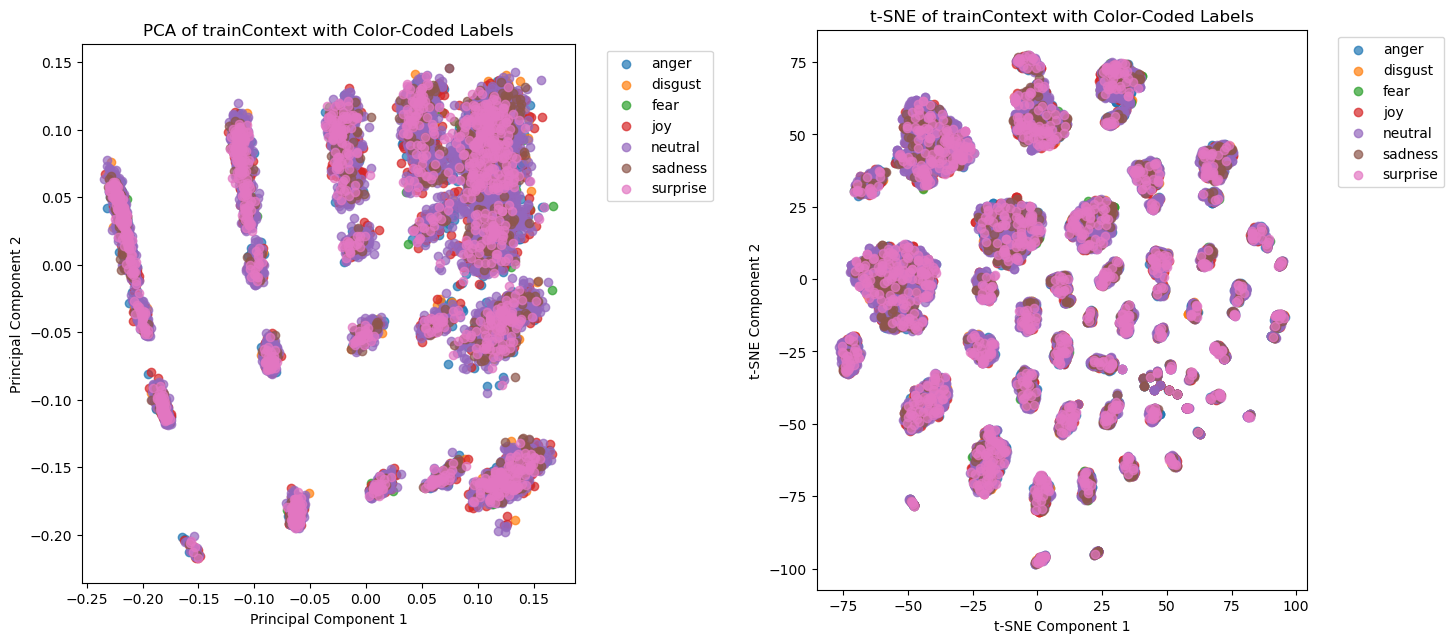

In [50]:
if True:
    # Assuming trainContext, X_train, and labelDecoder are already defined
    num_instance = len(X_train["Emotion"])

    # Calculate the counts for each unique label
    unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

    # Print the counts for each unique label
    for label, count in zip(unique_labels, label_counts):
        print(f"{labelDecoder[label]}: {count} occurrences")

    encodedFeaturesFlat = [speaker for dialogue in encodedSpeakersTrain for speaker in dialogue]
    trainContext = trainContext.squeeze(1)

    # Convert the tensor to a numpy array for use with sklearn
    trainContext_np = trainContext.detach().numpy()

    # Perform PCA
    pca = PCA(n_components=2)
    trainContext_pca = pca.fit_transform(trainContext_np)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    trainContext_tsne = tsne.fit_transform(trainContext_np)

    # Plot PCA results with color-coded labels  
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(trainContext_pca[indices, 0], trainContext_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of trainContext with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot t-SNE results with color-coded labels
    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(trainContext_tsne[indices, 0], trainContext_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of trainContext with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

<h4>Visualize node features (pre-h') with T-SNE and PCA

anger: 1445 occurrences
disgust: 356 occurrences
fear: 320 occurrences
joy: 2241 occurrences
neutral: 5658 occurrences
sadness: 853 occurrences
surprise: 1303 occurrences


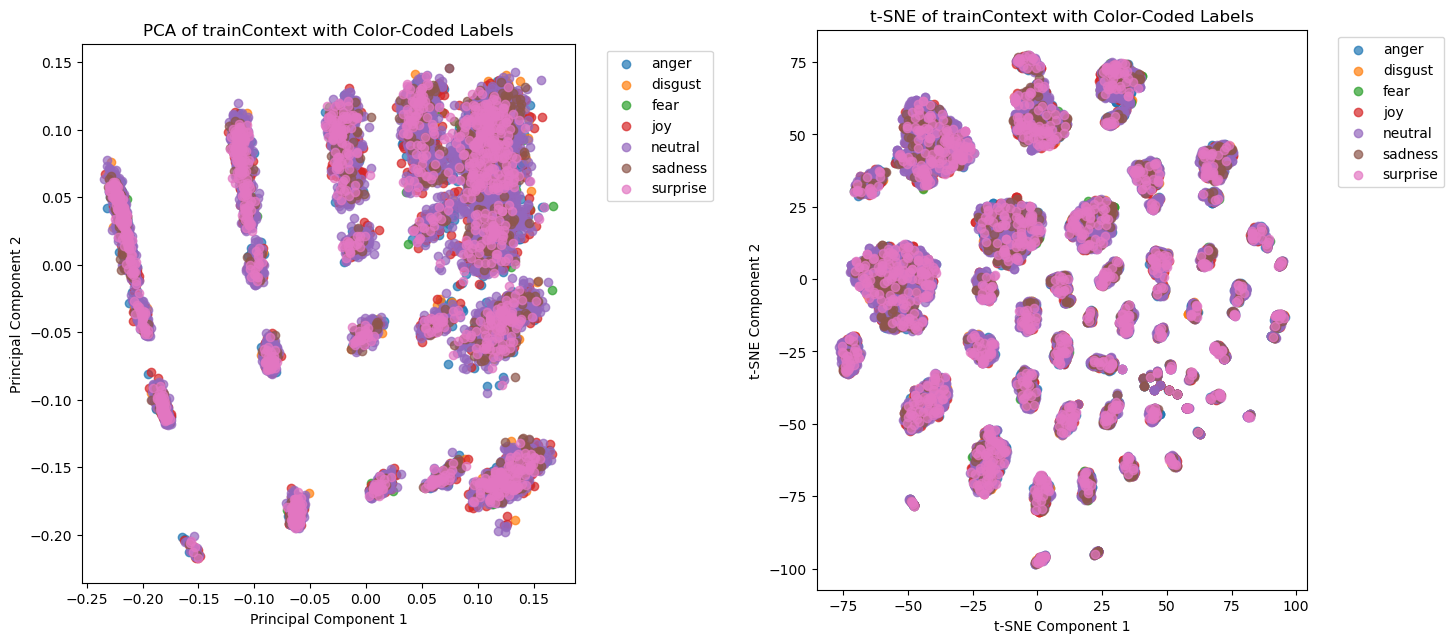

In [51]:
if True:
    # Assuming trainContext, X_train, and labelDecoder are already defined
    num_instance = len(X_train["Emotion"])

    # Calculate the counts for each unique label
    unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

    # Print the counts for each unique label
    for label, count in zip(unique_labels, label_counts):
        print(f"{labelDecoder[label]}: {count} occurrences")

    flattened_features = torch.cat(all_features, dim=0)

    # Convert the tensor to a numpy array for use with sklearn
    flattened_features_np = flattened_features.detach().numpy()

    # Perform PCA
    pca = PCA(n_components=2)
    flattened_features_np_pca = pca.fit_transform(flattened_features_np)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    flattened_features_tsne = tsne.fit_transform(flattened_features_np)

    # Plot PCA results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(flattened_features_np_pca[indices, 0], flattened_features_np_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of trainContext with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot t-SNE results with color-coded labels
    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(flattened_features_tsne[indices, 0], flattened_features_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of trainContext with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()